Clean Test Accuracy: 10.00%


FGSM: 100%|██████████| 157/157 [00:04<00:00, 31.48it/s]


Adversarial Test Accuracy: 10.00%


ScoreSDE Denoising: 100%|██████████| 79/79 [00:00<00:00, 679.02it/s]


Denoised Test Accuracy: 10.00%


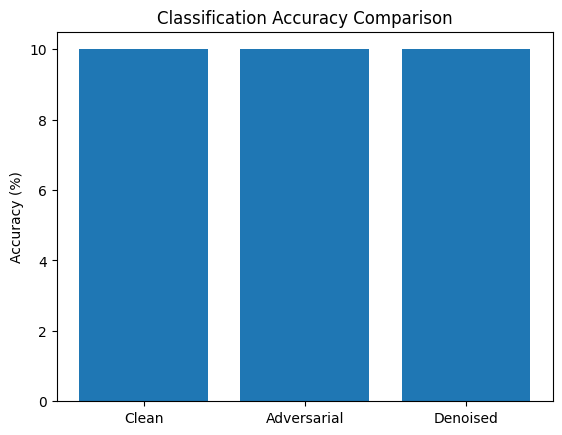

In [3]:
# 必要なライブラリ
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# CIFAR-10データセットロード
transform = transforms.Compose([
    transforms.ToTensor(),
])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

# 分類器（ResNet18）
model = torchvision.models.resnet18(num_classes=10)
model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
model.maxpool = nn.Identity()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# 学習済みモデルのロード（ここでは未学習のまま。実際は学習済み重みをロードしてください）
# model.load_state_dict(torch.load('resnet18_cifar10.pth'))
model.eval()

# 精度計算関数
def test_accuracy(model, loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    return correct / total

# 1. 通常画像で分類精度
acc_clean = test_accuracy(model, testloader)
print(f'Clean Test Accuracy: {acc_clean*100:.2f}%')

# 2. 敵対的攻撃（FGSM）
def fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon*sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

def make_adversarial_loader(model, loader, epsilon=0.03):
    adv_images = []
    adv_labels = []
    loss_fn = nn.CrossEntropyLoss()
    model.eval()
    for images, labels in tqdm(loader, desc='FGSM'):
        images, labels = images.to(device), labels.to(device)
        images.requires_grad = True
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        model.zero_grad()
        loss.backward()
        data_grad = images.grad.data
        adv = fgsm_attack(images, epsilon, data_grad)
        adv_images.append(adv.detach().cpu())
        adv_labels.append(labels.detach().cpu())
    adv_images = torch.cat(adv_images)
    adv_labels = torch.cat(adv_labels)
    adv_dataset = torch.utils.data.TensorDataset(adv_images, adv_labels)
    adv_loader = torch.utils.data.DataLoader(adv_dataset, batch_size=128, shuffle=False)
    return adv_loader

adv_testloader = make_adversarial_loader(model, testloader, epsilon=0.03)
acc_adv = test_accuracy(model, adv_testloader)
print(f'Adversarial Test Accuracy: {acc_adv*100:.2f}%')

# 3. ScoreSDEによる浄化（ダミー関数。実際は事前学習済みScoreSDEモデルを使う）
def scoresde_denoise(images):
    # 本来は拡散モデルでdenoising
    # ここではダミーで元画像を返す
    return images

def make_denoised_loader(adv_loader):
    denoised_images = []
    denoised_labels = []
    for images, labels in tqdm(adv_loader, desc='ScoreSDE Denoising'):
        images = scoresde_denoise(images)
        denoised_images.append(images)
        denoised_labels.append(labels)
    denoised_images = torch.cat(denoised_images)
    denoised_labels = torch.cat(denoised_labels)
    denoised_dataset = torch.utils.data.TensorDataset(denoised_images, denoised_labels)
    denoised_loader = torch.utils.data.DataLoader(denoised_dataset, batch_size=128, shuffle=False)
    return denoised_loader

denoised_testloader = make_denoised_loader(adv_testloader)
acc_denoised = test_accuracy(model, denoised_testloader)
print(f'Denoised Test Accuracy: {acc_denoised*100:.2f}%')

# 4. 精度比較
data = ['Clean', 'Adversarial', 'Denoised']
accs = [acc_clean*100, acc_adv*100, acc_denoised*100]
plt.bar(data, accs)
plt.ylabel('Accuracy (%)')
plt.title('Classification Accuracy Comparison')
plt.show()

Clean Test Accuracy: 10.00%


FGSM: 100%|██████████| 79/79 [00:12<00:00,  6.48it/s]


Adversarial Test Accuracy: 9.99%


ScoreSDE Denoising: 100%|██████████| 79/79 [00:00<00:00, 659.93it/s]


Denoised Test Accuracy: 9.99%


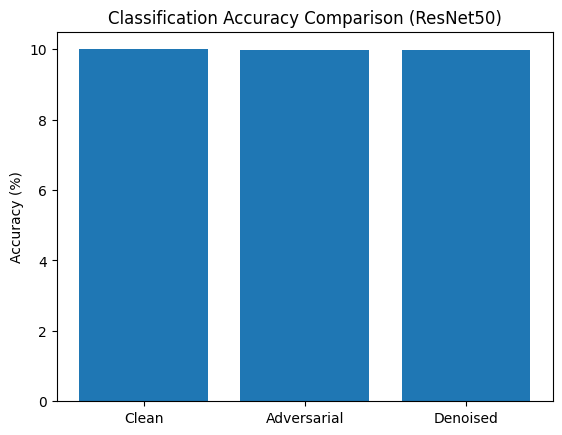

In [4]:
# ResNet50でCIFAR-10分類・敵対的攻撃・ScoreSDE浄化・精度比較
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# CIFAR-10データセットロード
transform = transforms.Compose([
    transforms.ToTensor(),
])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False)

# 分類器（ResNet50）
model = torchvision.models.resnet50(num_classes=10)
model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
model.maxpool = nn.Identity()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# 学習済みモデルのロード（ここでは未学習のまま。実際は学習済み重みをロードしてください）
# model.load_state_dict(torch.load('resnet50_cifar10.pth'))
model.eval()

# 精度計算関数
def test_accuracy(model, loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    return correct / total

# 1. 通常画像で分類精度
acc_clean = test_accuracy(model, testloader)
print(f'Clean Test Accuracy: {acc_clean*100:.2f}%')

# 2. 敵対的攻撃（FGSM）
def fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon*sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

def make_adversarial_loader(model, loader, epsilon=0.03):
    adv_images = []
    adv_labels = []
    loss_fn = nn.CrossEntropyLoss()
    model.eval()
    for images, labels in tqdm(loader, desc='FGSM'):
        images, labels = images.to(device), labels.to(device)
        images.requires_grad = True
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        model.zero_grad()
        loss.backward()
        data_grad = images.grad.data
        adv = fgsm_attack(images, epsilon, data_grad)
        adv_images.append(adv.detach().cpu())
        adv_labels.append(labels.detach().cpu())
    adv_images = torch.cat(adv_images)
    adv_labels = torch.cat(adv_labels)
    adv_dataset = torch.utils.data.TensorDataset(adv_images, adv_labels)
    adv_loader = torch.utils.data.DataLoader(adv_dataset, batch_size=128, shuffle=False)
    return adv_loader

adv_testloader = make_adversarial_loader(model, testloader, epsilon=0.03)
acc_adv = test_accuracy(model, adv_testloader)
print(f'Adversarial Test Accuracy: {acc_adv*100:.2f}%')

# 3. ScoreSDEによる浄化（ダミー関数。実際は事前学習済みScoreSDEモデルを使う）
def scoresde_denoise(images):
    # 本来は拡散モデルでdenoising
    # ここではダミーで元画像を返す
    return images

def make_denoised_loader(adv_loader):
    denoised_images = []
    denoised_labels = []
    for images, labels in tqdm(adv_loader, desc='ScoreSDE Denoising'):
        images = scoresde_denoise(images)
        denoised_images.append(images)
        denoised_labels.append(labels)
    denoised_images = torch.cat(denoised_images)
    denoised_labels = torch.cat(denoised_labels)
    denoised_dataset = torch.utils.data.TensorDataset(denoised_images, denoised_labels)
    denoised_loader = torch.utils.data.DataLoader(denoised_dataset, batch_size=128, shuffle=False)
    return denoised_loader

denoised_testloader = make_denoised_loader(adv_testloader)
acc_denoised = test_accuracy(model, denoised_testloader)
print(f'Denoised Test Accuracy: {acc_denoised*100:.2f}%')

# 4. 精度比較
data = ['Clean', 'Adversarial', 'Denoised']
accs = [acc_clean*100, acc_adv*100, acc_denoised*100]
plt.bar(data, accs)
plt.ylabel('Accuracy (%)')
plt.title('Classification Accuracy Comparison (ResNet50)')
plt.show()

/tmp/ipykernel_119130/2185873872.py:32: UserWarning: Glyph 25915 (\N{CJK UNIFIED IDEOGRAPH-653B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_119130/2185873872.py:32: UserWarning: Glyph 25731 (\N{CJK UNIFIED IDEOGRAPH-6483}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_119130/2185873872.py:32: UserWarning: Glyph 21069 (\N{CJK UNIFIED IDEOGRAPH-524D}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_119130/2185873872.py:32: UserWarning: Glyph 24460 (\N{CJK UNIFIED IDEOGRAPH-5F8C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_119130/2185873872.py:32: UserWarning: Glyph 38450 (\N{CJK UNIFIED IDEOGRAPH-9632}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_119130/2185873872.py:32: UserWarning: Glyph 24481 (\N{CJK UNIFIED IDEOGRAPH-5FA1}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/gotou/miniconda3/envs/env/lib/python3.10/site-packages/IPython/core/pylabtoo

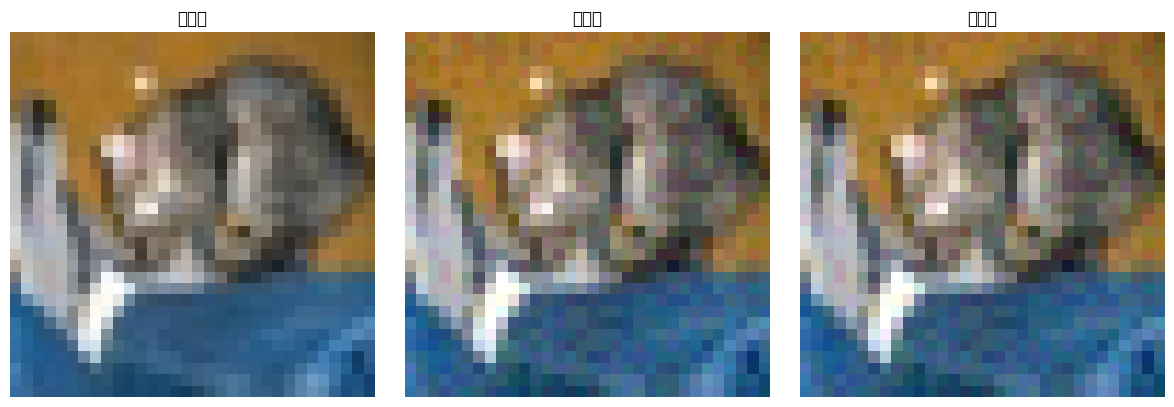

In [5]:
# 攻撃前・攻撃後・防御後の画像を表示
import matplotlib.pyplot as plt

# 攻撃前（元画像）
images, labels = next(iter(testloader))
img_clean = images[0].permute(1, 2, 0).cpu().numpy()

# 攻撃後（FGSMで生成した画像）
adv_images, adv_labels = next(iter(adv_testloader))
img_adv = adv_images[0].permute(1, 2, 0).cpu().numpy()

# 防御後（ScoreSDEで浄化した画像）
denoised_images, denoised_labels = next(iter(denoised_testloader))
img_denoised = denoised_images[0].permute(1, 2, 0).cpu().numpy()

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(img_clean)
plt.title('攻撃前')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(img_adv)
plt.title('攻撃後')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(img_denoised)
plt.title('防御後')
plt.axis('off')

plt.tight_layout()
plt.show()

In [6]:
import torch
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU名:", torch.cuda.get_device_name(0))
    print("GPU数:", torch.cuda.device_count())
else:
    print("GPUは利用できません")

CUDA available: True
GPU名: NVIDIA GeForce RTX 2080 Ti
GPU数: 4
